# Bike Sharing Demand

## CRISP-DM Approach

CRISP-DM stands for Cross-Industry Standard Process for Data Mining and describes a structured approach to understanding, preparing, modeling and evaluating data. This process includes the following steps:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

Deployment is not relevant for this type of project, as I won't be deploying my model to a web server. However, my results will be summarized in a blog post on Medium (https://medium.com/@julia.nikulski).

### 1. Business Understanding

### 2. Data Understanding

The data set is provided by the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). The dataset was created originally created by Fanaee-T and Gama (2013) in their study ["Event labeling combining ensemble detectors and background knowledge"](https://link.springer.com/article/10.1007/s13748-013-0040-3). The bike demand data in this data set comes from [Capital Bike Share](http://capitalbikeshare.com/system-data), the weather data was taken from [Free Meteo](http://www.freemeteo.com) and the holiday data is from the [DC Department of Human Resources](http://dchr.dc.gov/page/holiday-schedule). The dataset used data from the bike sharing stations of Capital Bike Share in Washington, D.C., USA. The weather data and holiday data refers to the same location.

In [71]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, pearsonr

import seaborn as sb
import matplotlib.pyplot as plt 

%matplotlib inline


### 3. Data Preparation

#### 3.1. Loading Data and visualizing and describing it

In [2]:
# read in bike sharing dataset
bike_df = pd.read_csv('bike-sharings.csv')
bike_df.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
# print descriptive statistics
bike_df.describe()


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [4]:
# check the datatypes of each variable
bike_df.dtypes


instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

Looking at these data types and what the features actually represent, I will convert some of them into categorical variables. 

In [5]:
# change data type of certain features from int to category
feat_int_to_cat = ['season', 'holiday', 'weekday', 'workingday', 'weathersit', 'dteday']

for feat in feat_int_to_cat:
    bike_df[feat] = bike_df[feat].astype('category')


##### Checking for missing values

In [6]:
# Check for missing values
bike_df.isnull().sum()


instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### 3.2. Preprocessing

Here I should already engineer some new columns based on existing ones (season, day, month, yr, etc.)

##### Dropping unnecessary columns

In [7]:
# drop the instant feature which is the same as the dataframe index +1
bike_df.drop(columns=['instant'], axis=1, inplace=True)


#### 3.3. Exploratory Data Analysis

##### Investigating individual columns

##### Season

In [8]:
# investigating feature 'season'
# print unique values of season feature
print(bike_df['season'].unique())

# create dummy variables for all 4 seasons
dummies_season = pd.get_dummies(bike_df['season'], prefix='season')

# remove season column from dataframe
bike_df.drop(columns=['season'], inplace=True)

# add dummy variables to dataframe
bike_df = pd.concat([bike_df, dummies_season], axis=1)

# change column names of the 4 season dummy variables
bike_df = bike_df.rename(columns={'season_1': 'season_spring', 'season_2': 'season_summer', 
                        'season_3': 'season_fall', 'season_4': 'season_winter'})

bike_df



[1, 2, 3, 4]
Categories (4, int64): [1, 2, 3, 4]


,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_spring,season_summer,season_fall,season_winter
0,2011-01-01,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,1,0,0,0
1,2011-01-02,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,1,0,0,0
2,2011-01-03,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,1,0,0,0
3,2011-01-04,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,1,0,0,0
4,2011-01-05,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,1,0,0,0
5,2011-01-06,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606,1,0,0,0
6,2011-01-07,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510,1,0,0,0
7,2011-01-08,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959,1,0,0,0
8,2011-01-09,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822,1,0,0,0
9,2011-01-10,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321,1,0,0,0


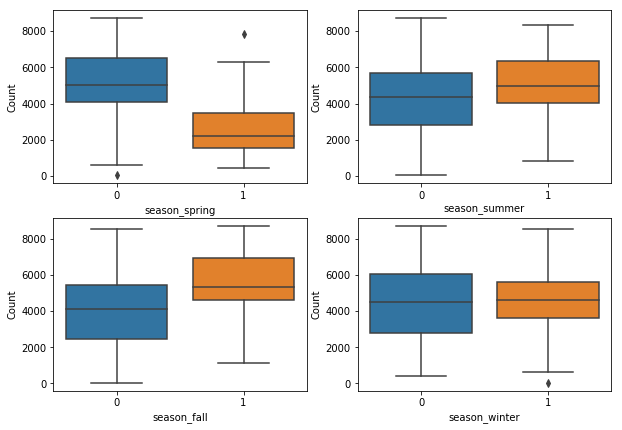

In [9]:
# variable to be used below to iterate through the columns and plot them
season_names = ['season_spring', 'season_summer', 'season_fall', 'season_winter']

# plotting the seasons vs. number of users in a boxplot
fig, ax = plt.subplots(2, 2, figsize = [10, 7])

count = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 1 and i == 2:
            break
        else:
            ax[j][i] = sb.boxplot(data = bike_df, x = season_names[count], y = 'cnt', ax=ax[j][i])
            ax[j][i].set_ylabel('Count')
            ax[j][i].set_xlabel(season_names[count])
            
        count += 1


The season feature clearly determines the customer demand for bikes, so this feature will be used for the final model.

##### dteday

In [10]:
# create new column with day of the month
bike_df['day'] = bike_df['dteday'].apply(lambda x: x[-2:])

# drop dteday feature
bike_df.drop(columns=['dteday'], axis=1, inplace=True)


In [11]:
bike_df.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_spring,season_summer,season_fall,season_winter,day
0,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,1,0,0,0,01
1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,1,0,0,0,02
2,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,1,0,0,0,03
3,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,1,0,0,0,04
4,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,1,0,0,0,05


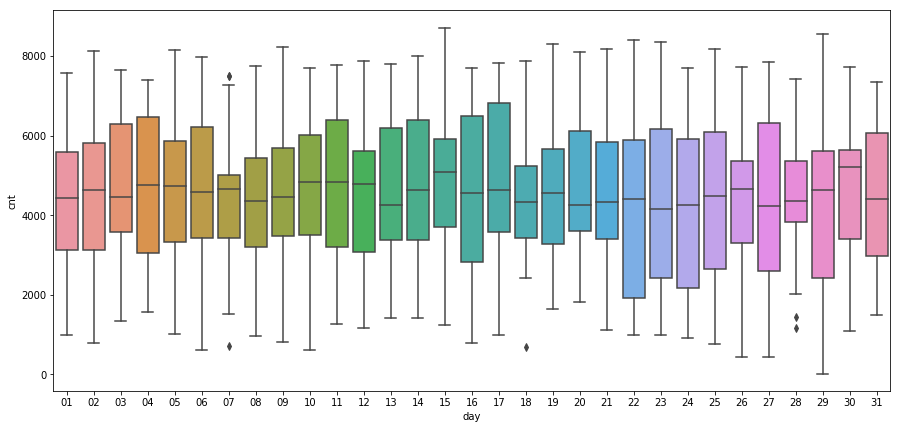

In [85]:
# plot number of users per day of month
plt.figure(figsize=[15,7])
sb.boxplot(x='day', y='cnt', data=bike_df);


##### temp

In [14]:
temp_per_month = bike_df.groupby('mnth')['temp'].mean()
temp_per_month

mnth
1     0.236444
2     0.299226
3     0.390539
4     0.469999
5     0.594798
6     0.684097
7     0.755470
8     0.708582
9     0.616485
10    0.485012
11    0.369220
12    0.324031
Name: temp, dtype: float64

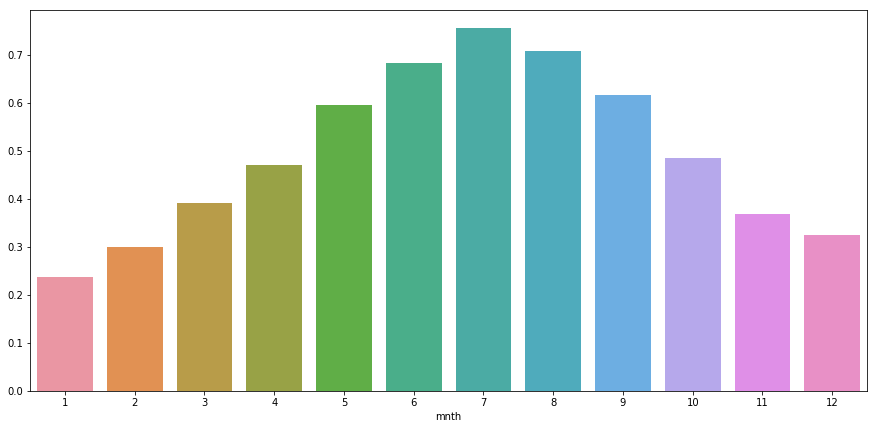

In [15]:
# plot number of users per day of month
plt.figure(figsize=[15,7])
sb.barplot(x=temp_per_month.index, y=temp_per_month.values);

In [16]:
mean_cnt_per_mnth = bike_df.groupby('mnth')['cnt'].mean()
mean_cnt_per_mnth

mnth
1     2176.338710
2     2655.298246
3     3692.258065
4     4484.900000
5     5349.774194
6     5772.366667
7     5563.677419
8     5664.419355
9     5766.516667
10    5199.225806
11    4247.183333
12    3403.806452
Name: cnt, dtype: float64

<Figure size 1080x504 with 0 Axes>

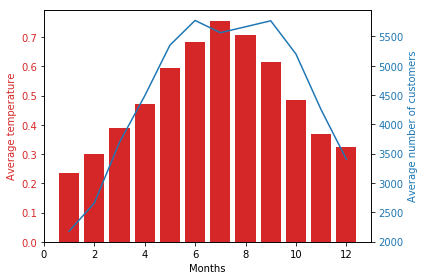

In [17]:
# assign x and y1 and y2
x = list(temp_per_month.index)
y1 = temp_per_month.values
y2 = mean_cnt_per_mnth.values

# below code adapted from https://matplotlib.org/gallery/api/two_scales.html
# creat plot containing both average count of customers
# and average temp per month
plt.figure(figsize=[15,7])
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color1 = 'tab:red'
ax1.set_xlabel('Months')
ax1.set_ylabel('Average temperature', color=color1)
ax1.bar(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2 = 'tab:blue'
ax2.set_ylabel('Average number of customers', color=color2)
ax2.plot(x, y2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout() 
plt.show()


##### yr

In [18]:
# split dataframe into two years
yr_2011 = bike_df[bike_df['yr'] == 0]
yr_2012 = bike_df[bike_df['yr'] == 1]

x_2011 = yr_2011.groupby('mnth')['cnt'].sum().index
y_2011 = yr_2011.groupby('mnth')['cnt'].sum().values

x_2012 = yr_2012.groupby('mnth')['cnt'].sum().index
y_2012 = yr_2012.groupby('mnth')['cnt'].sum().values


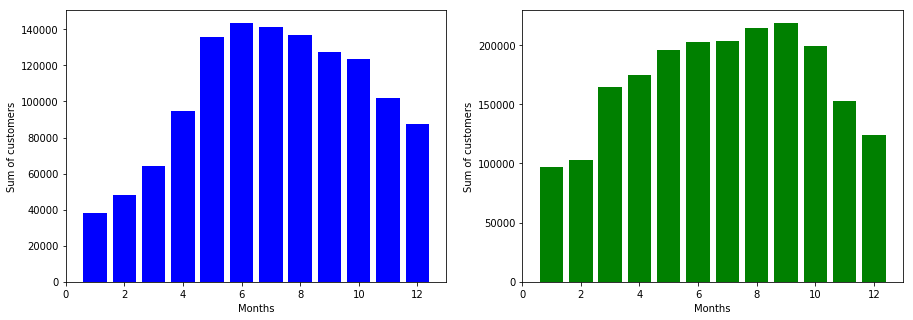

In [19]:
# plot count of customers for each year
plt.figure(figsize = [15, 5])

plt.subplot(1, 2, 1)
plt.bar(x_2011, y_2011, color='blue')
plt.xlabel('Months')
plt.ylabel('Sum of customers')

plt.subplot(1, 2, 2)
plt.bar(x_2012, y_2012, color='green')
plt.xlabel('Months')
plt.ylabel('Sum of customers');


##### mnth

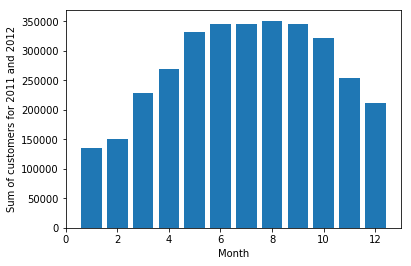

In [20]:
# plotting the total number of customers per month as a sum of both 2011 and 2012
sum_cnt_per_mnth = bike_df.groupby('mnth')['cnt'].sum()
x = sum_cnt_per_mnth.index
y = sum_cnt_per_mnth.values

plt.bar(x, y)
plt.xlabel('Month')
plt.ylabel('Sum of customers for 2011 and 2012');


##### holiday

The features holiday, weekday and workingday have some overlaps in their prediction of customer demand, thus, I will first analyze each individual feature and then investigate their correlation.

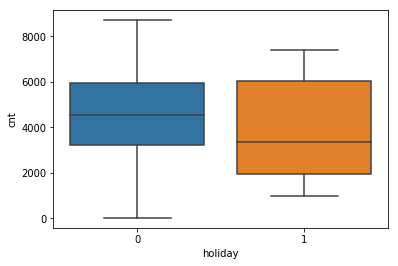

In [21]:
# plotting the customer statistics in form of a boxplot for the holiday feature
sb.boxplot(data = bike_df, x = 'holiday', y = 'cnt');


For the holiday feature, we can clearly see that there is on average a higher demand for bikes on days that are not holidays. This feature will be used in the final model to predict the overall demand.

In [66]:
# Correlation between holiday feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['holiday'], bike_df['cnt'])


KruskalResult(statistic=1237.4880012085603, pvalue=4.347245310989954e-271)

##### weekday

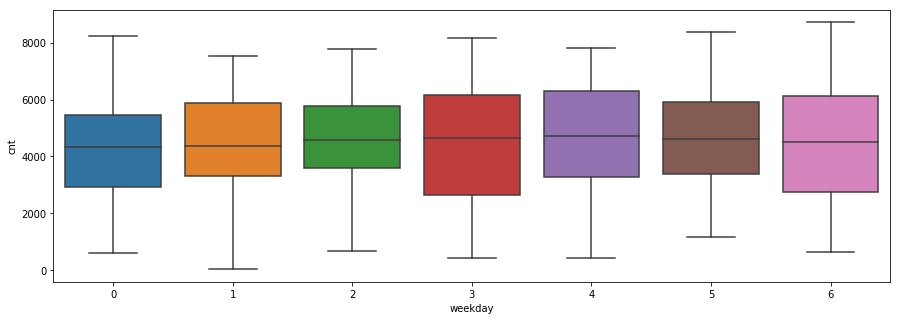

In [22]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize = [15, 5])
sb.boxplot(data = bike_df, x = 'weekday', y = 'cnt');


In [72]:
# Correlation between weekday feature and the number of customers per day
# using Pearson's correlation coefficient because I'm assuming that weekday can be 
# considered a continuous variable
pearsonr(bike_df['weekday'], bike_df['cnt'])


(0.06744341241063048, 0.06839080695470057)

Based on the above distributions of number of customers per weekday, it appears that there are slight difference in demand depending on what weekday it is. Thus, the weekday will be considered to forecast the bike demand.

##### workingday

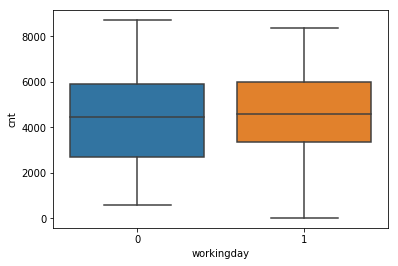

In [24]:
# plotting workday feature in boxplot against the count of customers
sb.boxplot(data = bike_df, x = 'workingday', y = 'cnt');


In [69]:
# Correlation between workingday feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['workingday'], bike_df['cnt'])


KruskalResult(statistic=1146.116725279893, pvalue=3.1322962418621962e-251)

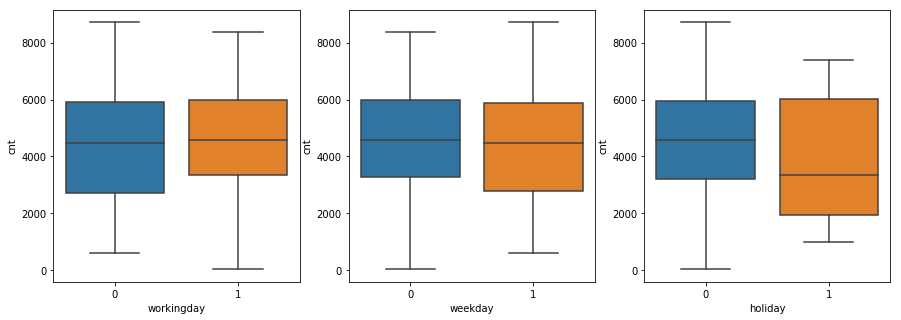

In [44]:
# create a new dataframe that encodes the weekday feature with 0 for monday through friday
# and 1 for saturday and sunday
weekend_distinct_df = bike_df.copy()
weekend_distinct_df['weekday'] = weekend_distinct_df['weekday'].apply(lambda x: 1 if (x == 6 or x == 0) else 0)

# plot boxplots for comparison between the weekday and workingday feature
plt.figure(figsize = [15, 5])

# boxplot for feature workingday
plt.subplot(1, 3, 1)
sb.boxplot(data = bike_df, x = 'workingday', y = 'cnt');

# boxplot for feature weekday
plt.subplot(1, 3, 2)
sb.boxplot(data = weekend_distinct_df, x = 'weekday', y = 'cnt');

# boxplot for feature holiday
plt.subplot(1, 3, 3)
sb.boxplot(data = bike_df, x = 'holiday', y = 'cnt');


In [56]:
# plot the means of each instance of workingday
bike_df.groupby('workingday')['cnt'].mean()


workingday
0    4330.168831
1    4584.820000
Name: cnt, dtype: float64

In [75]:
# plot the means of each instance of weekday
weekend_distinct_df.groupby('weekday')['cnt'].mean()


weekday
0    4550.566219
1    4389.685714
Name: cnt, dtype: float64

In [73]:
# plot the means of each instance of holiday
bike_df.groupby('holiday')['cnt'].mean()


holiday
0    4527.104225
1    3735.000000
Name: cnt, dtype: float64

The features holiday, weekday and workingday are correlated with each other as well as with the target variable cnt. However, they contain slightly different information that may be useful for predicting the target variable. Thus, I will keep all three variables for my model.

##### weathersit

The feature weathersit contains the following returns and meanings:
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [79]:
# Check which of these returns are part of our dataset
bike_df['weathersit'].unique()


[2, 1, 3]
Categories (3, int64): [2, 1, 3]

##### atemp

##### hum

##### windspeed

##### casual

##### registered

##### cnt

#### 3.4. Feature Selection

Add additional dataset --> need to research papers and decide what to add

Use PCA maybe?

### 4. Model

### 5. Evaluation